## Coding session part 1 : introduction to explainability and interpretability 

The goal of this coding session is to understand the fundamentals of applied explainability and interpretability. We will focus on simple principles such as how to interpret a basic model, how to use a database to make explanations more relevant. At the end of this session you should be able to : 
1. Interpret the coefficients of a linear regression globally and locally
2. Interpret a decision tree model globally and locally 
3. Code and interpret an partial dependence plot 
4. Code a simple version of LIME  

In [3]:
import numpy as np
import pandas as pd
import pylab as plt
from sklearn import tree as tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
# import pydotplus
# Import seaborn
import seaborn as sns
# Apply the default theme
sns.set_theme()

## Loading a toy dataset + one hot encoder

In [5]:
# Load data 
categorical_features = [
    'sex', 'marital_status',
    'relationship', #'education'
]
feature_names = [
    'age', 'education_num', # 'education',
    'marital_status',
    'relationship', 'sex', 'hours_per_week',
]

data = pd.read_csv("./adult.csv")
data.drop('fnlwgt', axis=1, inplace=True)
data.drop('race', axis=1, inplace=True)
# preprocess
data.replace('?', np.nan, inplace=True)
data.dropna(inplace=True)
data.replace(
    ['Divorced', 'Married-AF-spouse',
     'Married-civ-spouse', 'Married-spouse-absent',
     'Never-married', 'Separated', 'Widowed'],
    ['divorced', 'married', 'married', 'married',
     'not married', 'not married', 'not married'], 
    inplace=True)
data.reset_index(drop=True, inplace=True)
data['Income'] = data['Income'].apply(lambda x: x.replace('.', ''))
del data['occupation'], data['workclass']

# format output variable as a 0/1 output
data['Income'] = (data['Income'] == '>50K').astype(int)
x, y = data[feature_names], data['Income']

# encoding categorical features 
non_cate_features = [x for x in feature_names if x not in categorical_features]
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
one_hot_encoder = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)],
    remainder='passthrough',
    sparse_threshold=0,
)
one_hot_encoder.fit(x)
x_encoded = one_hot_encoder.transform(x)
cate_fnames = one_hot_encoder.transformers_[0][1]['onehot'].get_feature_names()
# put column name in the encoded feature name
cate_fname_full = [categorical_features[int(f.split('_')[0][1:])] + '__is__' + f[3:] for f in cate_fnames]
non_cate_features = [x for x in feature_names if x not in categorical_features]
col_names = list(cate_fname_full) + list(non_cate_features)
encoded_samples = pd.DataFrame(data=x_encoded, columns=col_names)
encoded_feature_names = encoded_samples.columns
# encoded_names_dict = {
#     k: list(filter(lambda x: x.split('__')[0] == k, encoded_feature_names))
#     for k in feature_names
# }

## 1.  Local Interpretable Model-agnostic Explanations (LIME) for tabular data

LIME is a popular explanation method discovered in 2016 by Marco Tulio Ribeiro. 

"An essential criterion for explanation is **local fidelity**. Although it is often impossible for an explanation to be completely faithful unless it is the complete description of the model itself, for an explanation to be meaningful it must at least be locally faithful, i.e. it must correspond to how the model behaves in the vicinity of the instance being predicted. We note that local fidelity does not imply global fidelity: features that are globally important may not be important in the local context, and vice versa. While global fidelity would imply local fidelity, identifying globally faithful explanations that are interpretable remains a challenge for complex models. 

An explainer should be able to explain any model, and thus be **model-agnostic** (i.e. treat the original model as a black box). Apart from the fact that many state-of-the-art classifiers are not currently interpretable, this also provides flexibility to explain future classifiers."

Original paper is available here: https://arxiv.org/pdf/1602.04938.pdf (recommended). 

According to this extract how should be classified LIME in the typology of explanation method? 

### 1.1 Step 1: sampling around an instance 

The first step toward a LIME-like explainer is to create a function capable of creating samples in the vicinity of any instance of the input space (data point). 

While there are several ways of acheiving this objective, we will focus today on the simplest one : random perturbation according to a gaussian distribution. Starting from an instance $X_{poe}$, point-of-interest, that we wish to explain predictions at, we create a dataset of the form $X_{poe} + \epsilon$ where $\epsilon \sim N(0, \sigma)$. Note that this approach only works with numerical data. 

Train a decision tree with only numerical features, it will play the role of our black-box model to be explained

In [6]:
numerical_data = [x for x in feature_names if x not in categorical_features]

# Train random forest 
X_train, X_test, y_train, y_test = train_test_split(data[numerical_data], y, test_size=.33)
dt = DecisionTreeClassifier(max_leaf_nodes=20)
dt.fit(X_train, y_train)
print("Accuracy score (test dataset): ", accuracy_score(y_test, dt.predict(X_test)))

Accuracy score (test dataset):  0.7924149021709997


Create a function that takes as argument $X_{poe}$ and that return a dataset containing k $X_{poe} + \epsilon$ where $\epsilon \sim N(0, \sigma)$ elements. 

In [14]:
dataset = data[numerical_data]
x_poe = dataset.sample(1)
k = 1000
sigma = dataset.std().values / 2.

def gaussian_sampling(x_poe, k, sigma):
    # Generate k samples of normally distributed noise with mean 0 and standard deviation sigma.
    noise = np.random.normal(loc=0, scale=sigma, size=(k, x_poe.shape[1]))
    # Add the noise to the original sample to generate k perturbed samples.
    samples = x_poe.values + noise
    # Convert the perturbed samples to a pandas DataFrame.
    samples = pd.DataFrame(samples, columns=x_poe.columns)

    return samples
    
x_poe_samples = gaussian_sampling(x_poe, k, sigma)
x_poe_samples

,age,education_num,hours_per_week
0,29.570287,6.119942,66.460239
1,56.786291,7.161592,61.969311
2,42.208097,6.747699,67.115953
3,35.858484,6.747908,71.550910
4,36.777556,10.145468,67.372137
...,...,...,...
995,35.833110,11.587465,68.914994
996,45.198216,9.120135,58.289323
997,48.363317,9.105740,66.489243
998,37.311641,6.401008,65.065217


### 1.2 Step 2 : train an interpretable classifier on these samples 

The second step to obtain a LIME-like classifier is to train an interpretable model on these samples. Although the black-box model may be globally very complex on the entire feature space, we can assume that it can be approximated locally with a very simple model. Then this simple model will inform us on the most significative features in the vicinity of $X_{poe}$. 

Today, for the sake of simplicity, we will us a linear model (Lasso) as our interpretable model. 

Train a linear regression on the samples and interpret the coefficient to have a local explanation. You may use results of last month to help you. 

In [15]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train a linear model (Lasso) on the perturbed samples
scaler = StandardScaler()
x_hat = scaler.fit_transform(X=x_poe_samples)
y = dt.predict(x_poe_samples)
X_train, X_test, y_train, y_test = train_test_split(x_hat, y, test_size=.33)
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

# Print the coefficient values and their corresponding feature names
coef_df = pd.DataFrame({'feature': x_poe.columns, 'coefficient': lasso.coef_})
print(coef_df)

# Print the accuracy score on the test set
accuracy = lasso.score(X_test, y_test)
print("Accuracy score (test dataset): ", accuracy)

          feature  coefficient
0             age          0.0
1   education_num          0.0
2  hours_per_week         -0.0
Accuracy score (test dataset):  0.0


Display the coefficients of the linear regression 

In [ ]:
print("Lasso coefficients:")
for i, coef in enumerate(lasso.coef_):
    print(f"{numerical_data[i]}: {coef:.4f}")

Questions : 
  - how you would interpret this explanation? 
  - can you verify that the explanation is correct? 
  - what are the effects of the parameters k, sigma and alpha on the final explanation? 

Bonus : 
  - find alternative ways of sampling in the vicinity of $X_{poe}$ and explain the differences with gaussian_sampling (hard)
  - find alternative interpretable models (hard)
  - create a datavizualization of the sampling and intertable model steps (medium)
  - how would you cope with categorical variables? 

## 2. LIME for images  

## 2.1 Use SLIC to divide an image in superpixels 

Use the scikit image package to generate segment of images.

Draw the resulting segmentation with the function mark_boundaries

What is the parameter of the process? 

Number of segments: 97


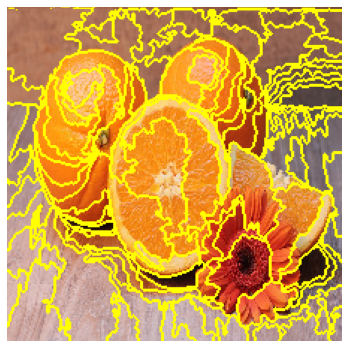

In [19]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut, cat, camera
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
#from keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img
#from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array


def process_image(image_path):
    original = load_img(image_path, target_size=(224, 224))
    numpy_image = img_to_array(original)
    return numpy_image

imr_choice = np.random.choice(['cat.jpg', 'dog.jpg', 'panda.jpg', 'orange.jpg'])
img = process_image("./images_examples/" + imr_choice)

segments_slic = slic(img, n_segments=200, compactness=10, sigma=1, start_label=1)

print(f'Number of segments: {len(np.unique(segments_slic))}')

fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)

ax.imshow(mark_boundaries(img / 255., segments_slic))
ax.set_axis_off()
plt.tight_layout()
plt.show()

## 2.2 Create samples based on these superpixels 

Use the following process to create n (n=5 for developing then n=300+) samples from the original image : 
1. randomly select K (K=10 is a good start) superpixels from the original image
2. create a perturbed version of the original image by coloring in grey rgb(128, 128, 128, ) the randomly selected superpixels 
3. store the generated sample and the corresponding list of greyed superpixels 

In [25]:
modif_sp = []
samples = []

for _ in range(10): # number of superpixels
    # randomly select a superpixel
    sp = np.random.choice(np.unique(segments_slic))
    modif_sp.append(sp)
    mask = segments_slic == sp
    
    # perturb the selected superpixel
    img[mask] = [128, 128, 128]
    samples.append(img.copy())

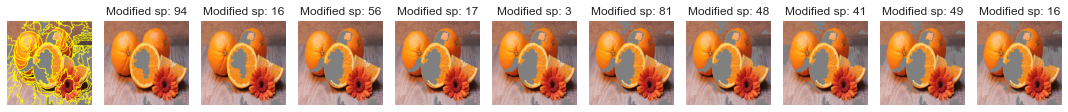

In [26]:
# display the modified image
fig, axes = plt.subplots(1, len(samples)+1, figsize=(15,5))
axes[0].imshow(mark_boundaries(img / 255., segments_slic))
axes[0].set_axis_off()

for i in range(len(samples)):
    axes[i+1].imshow(samples[i] / 255.)
    axes[i+1].set_axis_off()
    axes[i+1].set_title(f'Modified sp: {modif_sp[i]}')
    
plt.tight_layout()
plt.show()

Draw one randomly selected sample 

Pixel indices  56


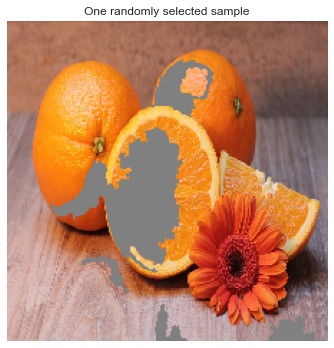

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

rand_sample_index = np.random.choice(len(samples))
rand_pix_indices = modif_sp[rand_sample_index]
ax.set_title("One randomly selected sample")
ax.imshow(samples[rand_sample_index] / 255)
print("Pixel indices ", rand_pix_indices)
ax.set_axis_off()
plt.tight_layout()
plt.show()

### 2.3 Use a pretrained image classifier

Using the VGG16 pretrained model, classify all samples and the original image. 

Create a function that return, for each sample, the predicted probability for the original predicted class. E.g. return the proba of the perturbed image being an astronaut accordind to the classification model. 

In [24]:
import numpy as np
from scipy.ndimage import gaussian_filter
import keras
import numpy as np
from keras.applications import vgg16
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt

vgg_model = vgg16.VGG16(weights='imagenet')

def model(img_array):
    processed_image = vgg16.preprocess_input(np.expand_dims(img_array, axis=0).copy())
    # get the predicted probabilities for each class
    predictions = vgg_model.predict(processed_image)
    return decode_predictions(predictions, top=1)[0][0]

original_image_prediction = model(img)
print()
print("Original image prediction:", original_image_prediction)

35363/35363 [==============================] - 0s 0us/step

Original image prediction: ('n07747607', 'orange', 0.9848164)


Using the the keras functions vgg16.preprocess_input, vgg_model.predict and decode_predictions, create a function that : 
 - takes as argument the list of samples and the original prediction 
 - for each sample, returns the proba corresponding to the original prediction (eg : proba of being an orange according to vgg16)
 - returns the list of proba 

In [53]:
def proba_output(image_list, output):
    # prepare the image for the VGG model
    image_array = np.copy(np.array(image_list))
    processed_image = vgg16.preprocess_input(image_array)
    # get the predicted probabilities for each class
    predictions = vgg_model.predict(processed_image)
    # convert the probabilities to class labels
    output_probabilities = np.array(decode_predictions(predictions, top=-1))
    
    # find the index of the original prediction
    original_index = None
    for i in range(output_probabilities.shape[1]):
        if output_probabilities[0, i, 1] == output:
            original_index = i
            break

    # extract the probabilities corresponding to the original prediction
    original_probas = []
    for image_index in range(output_probabilities.shape[0]):
        proba = output_probabilities[image_index, original_index, 0]
        original_probas.append(proba)

    return original_probas

original_probas = proba_output(samples, original_image_prediction)
original_probas

1/1 [==============================] - 3s 3s/step


[array([['n07747607', 'orange', '0.9836789']], dtype='<U32'),
 array([['n07747607', 'orange', '0.98702055']], dtype='<U32'),
 array([['n07747607', 'orange', '0.97748107']], dtype='<U32'),
 array([['n07747607', 'orange', '0.9790155']], dtype='<U32'),
 array([['n07747607', 'orange', '0.9781026']], dtype='<U32'),
 array([['n07747607', 'orange', '0.9742421']], dtype='<U32'),
 array([['n07747607', 'orange', '0.9529092']], dtype='<U32'),
 array([['n07747607', 'orange', '0.95596296']], dtype='<U32'),
 array([['n07747607', 'orange', '0.95821655']], dtype='<U32'),
 array([['n07747607', 'orange', '0.95821655']], dtype='<U32')]

### 2.4 Select and display the most significant superpixels

For each superpixel, compute the average probability (on all samples) of being classified as the original image. Select the 10 superpixel that have the lower average probability, they are the most significant ! 

In [54]:
proba_list = []

for sample in samples:
    proba = proba_output(sample, original_image_prediction)
    proba_list.append(proba)

avg_probs = []
for i in range(len(np.unique(segments_slic))):
    superpixel_prob = []
    for j in range(len(samples)):
        if modif_sp[i] in samples[j]:
            superpixel_prob.append(proba_list[j][original_prediction_index])
    avg_probs.append(np.mean(superpixel_prob))

sorted_sp = np.argsort(avg_probs)[:10]

fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)
ax.imshow(mark_boundaries(img / 255., segments_slic))
for sp in sorted_sp:
    c = np.random.rand(3,)
    ax.imshow(mark_boundaries(segments_slic == sp, segments_slic, color=c, alpha=0.5))
ax.set_axis_off()
plt.tight_layout()
plt.show()


2023-04-03 17:02:24.048959: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops_fused_impl.h:761 : INVALID_ARGUMENT: convolution input must be 4-dimensional: [32,224,3]
2023-04-03 17:02:24.049055: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: convolution input must be 4-dimensional: [32,224,3]
	 [[{{node vgg16/block1_conv1/Relu}}]]


InvalidArgumentError: Graph execution error:

Detected at node 'vgg16/block1_conv1/Relu' defined at (most recent call last):
    File "/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/opt/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/anaconda3/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/opt/anaconda3/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/opt/anaconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
      await result
    File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "/opt/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/gd/fy4sswmn2b13bsg74snxtc340000gn/T/ipykernel_50369/453467776.py", line 4, in <module>
      proba = proba_output(sample, original_image_prediction)
    File "/var/folders/gd/fy4sswmn2b13bsg74snxtc340000gn/T/ipykernel_50369/3071162117.py", line 6, in proba_output
      predictions = vgg_model.predict(processed_image)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in predict_step
      return self(x, training=False)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 321, in call
      return self.activation(outputs)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'vgg16/block1_conv1/Relu'
convolution input must be 4-dimensional: [32,224,3]
	 [[{{node vgg16/block1_conv1/Relu}}]] [Op:__inference_predict_function_876]

Vizualize these pixels